# Recherche théorique

Ce notebook regroupe nos avancées, nos solutions ainsi que différents tests.
Il sera divisé en deux parties, une consacrée au survol du drone et une au parcours des déneigeuses

## Partie drone

Hyptohèses: 
- On modélise les rues via un graphe
- Le graphe sera non orienté (pas de sens de circulation avec le drone)
- Chercher à parcourir toute les rues revient à chercher un chemin eulérien dans un graphe non orienté
- Le drone devra revenir à sont point de départ -> cycle eulérien
- Si le graphe peut ne pas avoir de cycle eulérien, à nous de l'adapter à cet objectif

Premier problème:
- Un cycle eulérien est soumis à la parité des sommets, et à sa connexité

Idée:
- Si la parité des sommets ne vas pas, on double des arrètes
- Utiliser un chemin optimiser pour le retour (Djikstra) -> idée rejetée

Remarque:
- Apres recherches, on comprends qu'il s'agit d'un probleme recurent appelé 'Chinese postman problem'

In [1]:
# Quelques imports
import math
import numpy as np

Il nous faut maintenant les différents algorithme de détection de cycle eulérien

In [2]:
# Count the odd vertices number
def odd_vertices(n, edges, weighted=True):
    deg = [0] * n
    if weighted:
        for (a,b,w) in edges:
            deg[a] += 1
            deg[b] += 1
    else:
        for (a,b) in edges:
            deg[a] += 1
            deg[b] += 1
    return [a for a in range(n) if deg[a] % 2]

def is_edge_connected(n, edges, weighted=True):
    if n == 0 or len(edges) == 0:
        return True
    succ = [[] for a in range(n)]
    if weighted:
        for (a,b,w) in edges:
            succ[a].append(b)
            succ[b].append(a)
    else:
        for (a,b) in edges:
            succ[a].append(b)
            succ[b].append(a)
    touched = [False] * n
    init = edges[0][0]
    touched[init] = True
    todo = [init]
    while todo:
        s = todo.pop()
        for d in succ[s]:
            if touched[d]:
                continue
            touched[d] = True
            todo.append(d)
    for a in range(n):
        if succ[a] and not touched[a]:
            return False
    return True

def is_eulerian(n, edges, weighted=True):
    return is_edge_connected(n, edges, weighted) and not odd_vertices(n, edges, weighted)

def find_eulerian_cycle(n, edges):
    assert is_eulerian(n, edges)
    if len(edges) == 0: 
        return []
    cycle = [edges[0][0]]
    while True:
        rest = []
        for (a, b) in edges:
            if cycle[-1] == a:
                cycle.append(b)
            elif cycle[-1] == b:
                cycle.append(a)
            else:
                rest.append((a,b))
        if not rest:
            assert cycle[0] == cycle[-1]
            return cycle[0:-1]
        edges = rest
        if cycle[0] == cycle[-1]:
            for (a, b) in edges:
                if a in cycle:
                    idx = cycle.index(a)
                    cycle = cycle[idx:-1] + cycle[0:idx+1]
                    break

### Solution basique

Une première idée de solution est la suivante :
- lister tous les sommets de degré impair

Tant que la liste n'est pas vide
- prendre un sommet au hasard
- calculer Bellman-ford avec comme source le sommet
- prendre le sommet le plus proche de la source
- rajouter la liaison entre les deux au graphe
- supprimer les deux sommets de la liste

In [3]:
def bellman_ford(n, edges, src):
    dist = [math.inf] * n
    dist[src] = 0
    for k in range(n - 1):
        save = dist.copy()
        for (src, dest, weight) in edges:
            dist[dest] = min(dist[dest], dist[src] + weight)
            dist[src] = min(dist[src], dist[dest] + weight)
        if save == dist:
            break
    return dist

def closest(dist, odd, src):
    minimum = math.inf
    i_min = src
    for i in odd:
        if i != src and dist[i] < minimum:
            minimum = dist[i]
            i_min = i
    return i_min


def make_eulerian_v1(n, edges):
    odd = odd_vertices(n, edges)
    
    while len(odd) > .0:
        src = odd.pop()
        dist = bellman_ford(n, edges, src)
        dest = closest(dist, odd, src)
        edges.append((src, dest, dist[dest]))
        odd.remove(dest)
        
    return edges

On peut maintenant vérifier notre solution et prendre les performances.

In [4]:
%%capture
#On import quelques outils pour les test et la visualisation
!pip install osmnx
!pip install pyvis
!pip install pydot
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from IPython.display import Image, display
import pydot

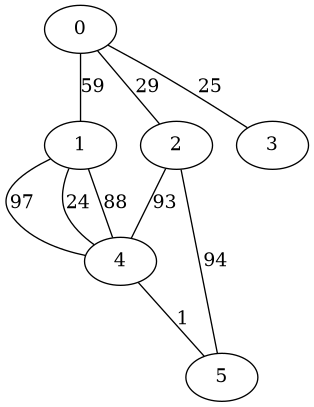

Is G1 eulerian:  False
Is G2 eulerian:  False
Is G3 eulerian:  False
Is G4 eulerian:  False


In [5]:
# Connected graph Generator
#Input:
#    N - size of generated graph
#    S - edges (from N-1 to N(N-1)/2)
#Output:
#    simple connected graph G(v,e) with N vertices and S edges (Undirected) and ramdomly weighted
def connectedGenerator(n, s):
  edges = []
  nodes = [0]
  for i in range(1, n):
    elt = random.choice(nodes)
    w = random.randint(1,100)
    edges.append((elt, i, w))
    nodes.append(i)
  while len(edges) < s:
    src = random.choice(nodes)
    dest = random.choice(nodes)
    while src == dest:
      dest = random.choice(nodes)
    weight = random.randint(1,100)
    edges.append((src, dest, weight))
  assert is_edge_connected(n, edges)
  return n, edges

# Counter to name displayed dot
printed = 0
def graph_printer(edges, printed):
    G=nx.MultiGraph()
    for (src, dest, w) in edges:
        G.add_edge(src, dest, weight=w)
    for edge in G.edges(data=True): edge[2]['label'] = edge[2]['weight']
    node_label = nx.get_node_attributes(G,'id')
    pos = nx.spring_layout(G)
    node_label = nx.get_node_attributes(G,'id')
    pos = nx.spring_layout(G)
    p=nx.drawing.nx_pydot.to_pydot(G)
    p.write_png('multi'+str(printed)+'.png')
    display(Image(filename='multi'+str(printed)+'.png'))
    return printed + 1
    

n1, e1 = connectedGenerator(6, 9)
printed = graph_printer(e1, printed)
n2, e2 = connectedGenerator(30, 60)
e2_bis = e2.copy() #For later test
n3, e3 = connectedGenerator(100, 5000)
n4, e4 = connectedGenerator(1000, 30000)
print("Is G1 eulerian: ", is_eulerian(n1, e1.copy()))
print("Is G2 eulerian: ", is_eulerian(n2, e2.copy()))
print("Is G3 eulerian: ", is_eulerian(n3, e3.copy()))
print("Is G4 eulerian: ", is_eulerian(n4, e4.copy()))

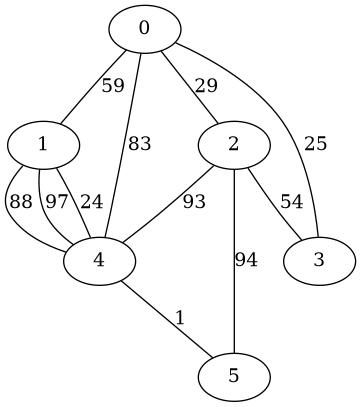

Is G1 eulerian:  True
CPU times: user 18.4 ms, sys: 662 µs, total: 19.1 ms
Wall time: 57.3 ms


In [6]:
%%time
d1 = make_eulerian_v1(n1, e1)
printed = graph_printer(d1, printed)
print("Is G1 eulerian: ", is_eulerian(n1, d1))

In [7]:
%%time
d2 = make_eulerian_v1(n2, e2)
print("Is G2 eulerian: ", is_eulerian(n2, d2))

Is G2 eulerian:  True
CPU times: user 3.02 ms, sys: 0 ns, total: 3.02 ms
Wall time: 2.87 ms


In [8]:
%%time
d3 = make_eulerian_v1(n3, e3)
print("Is G3 eulerian: ", is_eulerian(n3, d3))

Is G3 eulerian:  True
CPU times: user 226 ms, sys: 0 ns, total: 226 ms
Wall time: 225 ms


In [9]:
%%time
d4 = make_eulerian_v1(n4, e4)
print("Is G4 eulerian: ", is_eulerian(n4, d4))

Is G4 eulerian:  True
CPU times: user 22.2 s, sys: 21 ms, total: 22.2 s
Wall time: 22.6 s


### Solution optimale

On cherche maintenant à trouver une solution optimale à l'ajout d'arêtes dans le graphe.
L'algorithme se décompose comme cela:
- Lister les sommets de degré impair
- Calculer l'ensemble des pemutations possibles des arêtes entre les noeuds précédent
- Pour chaque permutation, calculer la distance total engendré avec Bellman-Ford
- Garder la permutation avec la plus petite distance totale
- Rajouter les arêtes générés au graphe

In [10]:
######## Solution tools ###########

def all_pairs(nodes):
    if len(nodes) < 2:
        yield []
        return
    if len(nodes) % 2 == 1:
        for i in range(len(nodes)):
            for res in all_pairs(nodes[:i] + nodes[i+1:]):
                yield res
    else:
        a = nodes[0]
        for i in range(1,len(nodes)):
            pair = (a,nodes[i])
            for rest in all_pairs(nodes[1:i]+nodes[i+1:]):
                yield [pair] + rest
                
def total_cost(edges):
    total = 0
    for (src, dest, weight) in edges:
        total += weight
    return total

In [11]:
def make_eulerian_v2(n, edges):
    # Get all the odd vertice
    odd = []
    weights = [[0] * n for i in range(n)]
    degrees = [0] * n
    for (src, dest, weight) in edges:
        degrees[src] += 1
        degrees[dest] += 1
        weights[src][dest] = weight
    for i in range(n):
        if degrees[i] % 2 != 0:
            odd.append(i)

    # Make all possible pair with odd vertice
    pairsPermutation = list(all_pairs(odd))

    # Find the best permutation
    sumed = []
    dist = [None] * n
    for perm in pairsPermutation:
        total = 0
        for (src, dest) in perm:
            new_dist = bellman_ford(n, edges, src)
            dist[src] = new_dist
            total += new_dist[dest]
        sumed.append(total)

    # Add corresponding edge
    costless = np.argmin(sumed)
    for (src, dest) in pairsPermutation[costless]:
        edges.append((src, dest, dist[src][dest]))
    return edges

On peut maintenant analyser les résultat. On fera l'étude sur un petit graphe de par la complexité algorithmique de cette solution.

In [13]:
d2_bis = make_eulerian_v2(n2, e2_bis)
print("Is G1_bis eulerian: ", is_eulerian(n2, d2_bis))
print("Total cost for G1 = ", total_cost(d2))
print("Total cost for G1_bis = ", total_cost(d2_bis))

Is G1_bis eulerian:  True
Total cost for G1 =  3454
Total cost for G1_bis =  3376


On observe alors une solution optimale